<a href="https://colab.research.google.com/github/gustavo-maranhao/anti-fraud-transactions/blob/main/Anti_Fraud_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import json
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

# Loading the CSV file
df = pd.read_csv('https://raw.githubusercontent.com/gustavo-maranhao/anti-fraud-transactions/main/database.csv')

In [33]:
# Adding "BIN" column
df['card_bin'] = df['card_number'].str[:6]
df["transaction_date"] = pd.to_datetime(df["transaction_date"])


In [34]:
# Percentage of chargebacks per BIN
df = (
    df
    .assign(
        sum_bin = lambda x: x.groupby('card_bin')['has_cbk'].transform('sum'),
        total_bin = lambda x: x.groupby('card_bin')['has_cbk'].transform('size'),
        percentual_bin = lambda x: round((x['sum_bin']/x['total_bin']) * 100, 2)
    )
)

In [35]:
# Display descriptive statistics of percentage of chargebacks per BIN
(
    df
    .groupby('card_bin', as_index = False)
    .agg(
      sum_bin = ('has_cbk', 'sum'),
      total_bin = ('has_cbk', 'size')
    )
    .assign(
        percentual = lambda x: round((x['sum_bin']/x['total_bin']) * 100, 2)
    )
    .query('total_bin >= 7')
    .sort_values('percentual')
)['percentual'].describe()

count    115.000000
mean      12.888957
std       17.913703
min        0.000000
25%        0.000000
50%        5.260000
75%       21.540000
max      100.000000
Name: percentual, dtype: float64

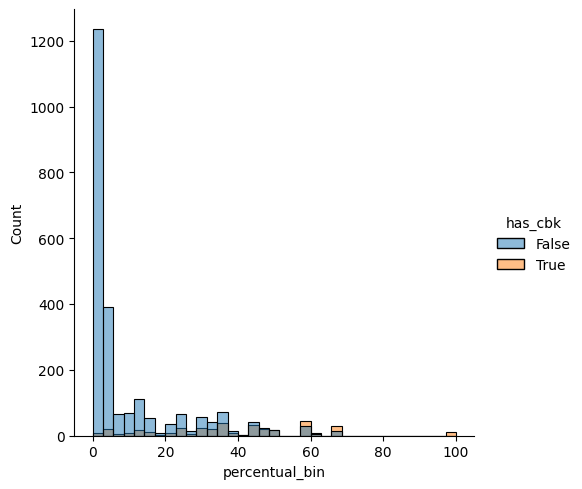

In [36]:
# Plot histogram of percentage of chargebacks per BIN
sns.displot(data = df.query('total_bin >= 5'), x = 'percentual_bin', hue ='has_cbk')

In [37]:
# Display the number of unique users per card number
df.groupby('card_number', as_index = False)['user_id'].nunique().sort_values('user_id')

,card_number,user_id
0,222763******3026,1
1939,536805******6868,1
1940,536805******6977,1
1941,536805******7429,1
1942,536832******9759,1
...,...,...
2744,606282******4880,2
261,412177******1138,2
2490,550209******6408,2
2493,550209******6420,3


In [38]:
# Display the number of unique card numbers per user
df.groupby('user_id', as_index = False)['card_number'].nunique().sort_values('card_number')

,user_id,card_number
0,6,1
1776,67558,1
1777,67650,1
1778,67681,1
1779,67698,1
...,...,...
2582,96025,10
2085,78262,10
2103,79054,15
2448,91637,22


In [39]:
# Display descriptive statistics of transaction amount grouped by chargeback status
df.groupby('has_cbk')['transaction_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
has_cbk,,,,,,,,
False,2808.0,672.324380,797.463853,1.22,191.285,360.315,812.5775,4091.83
True,391.0,1453.571918,1169.491346,2.89,565.580,999.470,2140.6800,4097.21


In [40]:
# Display the number of unique users with transaction amount > 1000 and percentage of chargebacks per BIN > 22 and has_cbk == True
df.query('transaction_amount > 1000 and percentual_bin > 22 and has_cbk == True')['user_id'].nunique()

83

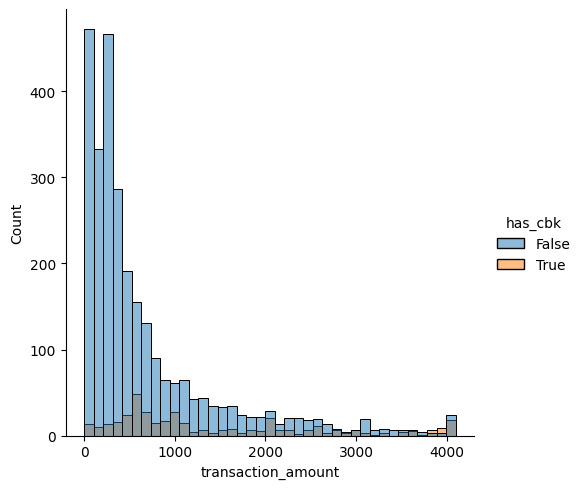

In [41]:
# Plot histogram of transaction amount with hue as chargeback status
sns.displot(data = df, x = 'transaction_amount', hue ='has_cbk')

In [42]:
# Function: Reject transactions from USER that have had chargebacks in the past
def has_chargeback(user_id):
    return df[(df["user_id"] == user_id) & (df["has_cbk"] == True)].shape[0] > 0

# Function: Reject transactions from CARD that have had chargebacks in the past
def has_chargeback_card(card_number):
    return df[(df["card_number"] == card_number) & (df["has_cbk"] == True)].shape[0] > 0

# Function to apply the rules and get the recommendation
def get_recommendation(transaction):

    # Rule 1: Deny transactions if user_id or card_number has had chargebacks before
    if has_chargeback(transaction["user_id"]):
        return "deny"

    if  has_chargeback_card(transaction["card_number"]):
        return "deny"

    # Rule 2: Deny transactions with high value and BIN with high chargeback rate
    if (transaction['transaction_amount'] > 1000) & (df.query('percentual_bin > 22 and total_bin > 7')['card_bin'].isin([transaction['card_number'][:6]]).sum() > 0) & (df.query('has_cbk == True')['user_id'].isin([transaction['user_id']]).sum() > 0):
      return "deny"

    # Rule 3: Deny transactions if there have been 4 or more attempts of the same purchase within 5 minutes
    recent_transactions = df[
        (df["user_id"] == transaction["user_id"]) &
        (df["transaction_id"] == transaction["transaction_id"])
    ]
    if len(recent_transactions) > 4:
        transaction_date = datetime.strptime(transaction["transaction_date"], "%Y-%m-%dT%H:%M:%S.%f")
        if (datetime.now() - transaction_date) <= timedelta(minutes=5):
            return "deny"

    # If no rule denies the transaction, approve it
    return "approve"

In [43]:
# Transaction Request
transaction = {
    "transaction_id": 2342357,
    "merchant_id": 29744,
    "user_id": 97051,
    "card_number": "434505******9116",
    "transaction_date": "2019-11-31T23:16:32.812632",
    "transaction_amount": 373,
    "device_id": 285475
}

recommendation = get_recommendation(transaction)
recommendation_data = {
    "transaction_id": transaction["transaction_id"],
    "recommendation": recommendation
}
recommendation_json = json.dumps(recommendation_data, indent=4)
print(recommendation_json)

{
    "transaction_id": 2342357,
    "recommendation": "approve"
}


In [44]:
# Metrics to evaluate model: F1 Score and Confusion Matrix
from sklearn.metrics import f1_score, confusion_matrix

lista_preds = []
label_map = {'deny': 0, 'approve': 1}

for index, row in df[['transaction_id', 'merchant_id', 'user_id', 'card_number', 'transaction_date', 'transaction_amount', 'device_id']].iterrows():
    lista_preds.append(get_recommendation({
        "transaction_id": row['transaction_id'],
        "merchant_id": row['merchant_id'],
        "user_id": row['user_id'],
        "card_number": row['card_number'],
        "transaction_date": row['transaction_date'],
        "transaction_amount": row['transaction_amount'],
        "device_id": row['device_id']
    }))

# Convert the predictions from strings to numerical values
lista_preds_numerical = [label_map[pred] for pred in lista_preds]

# Calculate the confusion matrix and F1 score
print(confusion_matrix(df['has_cbk'], lista_preds_numerical))
print(f1_score(df['has_cbk'], lista_preds_numerical))

[[  70 2738]
 [ 391    0]]
0.0
